# Euler Method

In [53]:
from typing import Callable, NamedTuple
from functools import cache

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import sympy as sy
from tqdm import tqdm

from ipywidgets.widgets import interact, FloatSlider, Layout

In [54]:
np.set_printoptions(suppress=True)

plt.style.use("bmh")
config = {'figure.figsize': (18, 4),
          'axes.titlesize': 18,
          'axes.labelsize': 10,
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

In [55]:
Function = Callable[[sy.Symbol, sy.Symbol], sy.Expr]

ODESolver = Callable[["ODEInfo"], tuple[npt.ArrayLike, npt.ArrayLike]]

class ODEInfo(NamedTuple):
    function: Function
    initial_value: float
    time_step: float
    time_final: float
    title: str | None = None

    @property
    def time(self) -> npt.NDArray[np.float32]:
        return np.arange(0, self.time_final + self.time_step, self.time_step) 

    @property
    def as_lambda(self) -> Callable[[npt.NDArray[np.complex128]], npt.NDArray[np.complex128]]:
        y_sym = sy.Function('y')
        x_sym = sy.Symbol('x')

        symbolic_function = self.function(x_sym, y_sym(x_sym))
        equation = sy.Eq(symbolic_function, y_sym(x_sym).diff(x_sym))

        solution = sy.dsolve(equation, ics={y_sym(0): self.initial_value})
        return sy.lambdify(x_sym, solution.rhs, 'numpy')

    @cache
    def solve(self, solver: ODESolver) -> tuple[npt.ArrayLike, npt.ArrayLike]:
        return solver(self)
    
    @cache
    def solve_analytical(self) -> tuple[npt.ArrayLike, npt.ArrayLike]:
        return self.time, self.as_lambda(self.time)

## Explicit Euler Method

In [56]:
def euler_explicit(info: ODEInfo) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    y = info.initial_value
    ys = [y] + [y := y + info.time_step * info.function(x, y) for x in info.time[:-1]]
    return info.time, np.array(ys)

## Implicit Euler Method

In [57]:
def euler_implicit(info: ODEInfo) -> tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]:
    y_k = sy.Symbol("y_{k}")
    x_k1 = sy.Symbol("x_{k+1}")
    y_k1 = sy.Symbol("y_{k+1}")

    euler_formula = sy.Eq(y_k + info.time_step * info.function(x_k1, y_k1), y_k1)
    solution, *_ = sy.solve(euler_formula, y_k1)
    
    y = info.initial_value
    ys = [y] + [y := sy.re(solution.subs({y_k: y, x_k1: x})) for x in info.time[1:]]
        
    return info.time, np.array(ys)

## Parametrization

In [ ]:
def variation_h(h: float, real_coefficient: float, imaginary_coefficient: float, max_time: int):
    coefficient = (real_coefficient + imaginary_coefficient * 1j)
    ode_info = ODEInfo(lambda x, y: coefficient*y, 35, h, max_time)

    x_explicit, y_explicit = euler_explicit(ode_info)
    x_implicit, y_implicit = euler_implicit(ode_info)

    xs = np.linspace(0, ode_info.time_final, 1000)
    ys = ode_info.as_lambda(xs)

    plt.plot(xs, ys, label='Analytic Solution', alpha=0.4, lw=5)

    plt.plot(x_explicit, np.real(y_explicit), 'o--', markersize=8, label='Approximation (Explicit)', color='darkcyan')
    plt.plot(x_implicit, np.real(y_implicit), 'o--', markersize=8, label='Approximation (Implicit)', color='firebrick')

    plt.title('Euler Method - Variation of $h$')
    plt.xlabel('t')
    plt.ylabel('f(t)')

    plt.legend()


    plt.tight_layout()
    plt.show()
    
interact(variation_h, 
    h=FloatSlider(min=0, max=4, step=0.01, value=1, layout=Layout(width='99%'))
    real_coefficient=FloatSlider(min=-3, max=3, step=0.1, value=-1, layout=Layout(width='99%'))
    imaginary_coefficient=FloatSlider(min=-3, max=3, step=0.1, value=0, layout=Layout(width='99%'))
    max_time=FloatSlider(min=1, max=50, step=1, value=20, layout=Layout(width='99%'))
);

interactive(children=(FloatSlider(value=1.0, description='h', layout=Layout(width='99%'), max=4.0, step=0.01),…

## Examples

In [59]:
odes = [
    ODEInfo(lambda x, y: 0.1*y, 1, 1, 20, "$y' = 0.1 y$"),
    ODEInfo(lambda x, y: 2*x - 2*y, 1, 0.1, 5, "$y' = 2x - 2y$"),
    ODEInfo(lambda x, y: x*y**2 + 2*y, -5, 0.1, 5, "$y' = xy^2 + 2y$"),
]

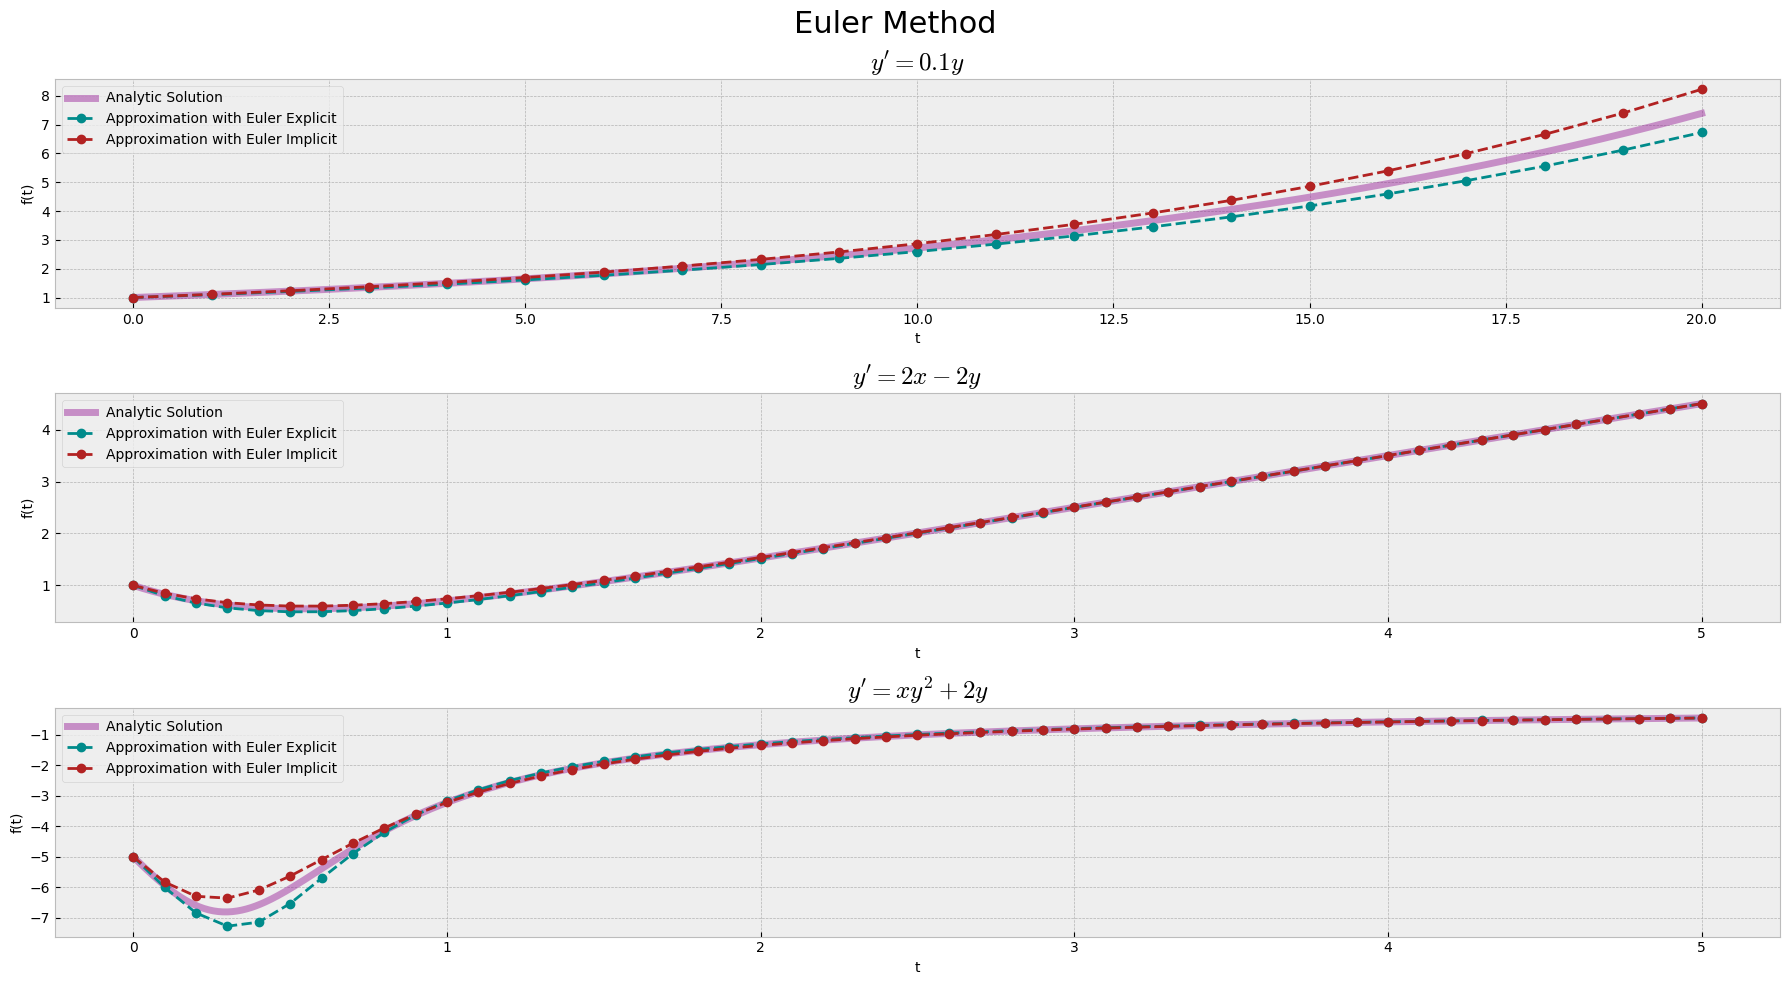

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

for ax, ode in zip(axes.flatten(), odes):
    x_explicit, y_solution = euler_explicit(ode)
    x_implicit, y_implicit = euler_implicit(ode)
    
    xs = np.linspace(0, ode.time_final, 1000)
    ys = ode.as_lambda(xs)

    ax.plot(xs, ys, label='Analytic Solution', alpha=0.4, lw=5)

    ax.plot(x_explicit, y_solution, 'o--', markersize=6, label='Approximation with Euler Explicit', color='darkcyan')
    ax.plot(x_implicit, y_implicit, 'o--', markersize=6, label='Approximation with Euler Implicit', color='firebrick')
    
    ax.set_title(ode.title)
    ax.set_xlabel('t')
    ax.set_ylabel('f(t)')
    
    ax.legend()

plt.suptitle('Euler Method', fontsize=22)
plt.tight_layout()
plt.show()

En el gráfico anterior se puede ver como el implícito siempre aproxima por encima y el explícito por debajo

## Deep Dive

### Varying Step Size - Keeping same Coeeficients

In [61]:
def compute_error(info: ODEInfo, time_steps: npt.ArrayLike, solver: ODESolver) -> npt.ArrayLike:
    results = []
    solved_ode = info.as_lambda
    last_ys = solved_ode(info.time[-1])
    for time_step in tqdm(time_steps):
        info = info._replace(time_step=time_step)
        _, y_solution = info.solve(solver)
        error = last_ys - y_solution[-1]
        results.append(error)
    
    return np.array(results)

In [62]:
initial_value = 35
initial_time_step = 2
final_time = 20
coeff = -1
info = ODEInfo(lambda x, y: coeff*y, 35, 1, 20)

time_steps = np.linspace(0.1, 3, 400)

#### Explicit Euler

In [63]:
stability_limit = 2 / np.abs(coeff)
oscillatory_limit = - 1 / coeff

results = compute_error(info, time_steps, euler_explicit)

100%|██████████| 400/400 [00:00<00:00, 14279.82it/s]


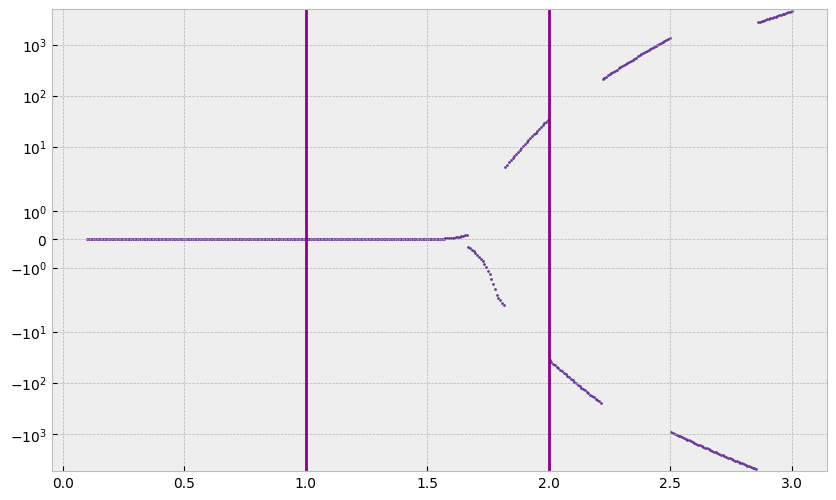

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(time_steps, results, color="rebeccapurple", s=2)

plt.axvline(stability_limit)
plt.axvline(oscillatory_limit)
plt.yscale('symlog')
plt.show()

Este gráfico muestra que a medida que el step size se hace más grande, el valor absoluto del error se incrementa, y que a partir de cierto valor, se empiezan a ver oscilaciones entre valores positivos y negativos.

El punto de no retorno es cuando el coefficiente multiplicado por el paso supera a 2 y el momento cuando se ven oscilaciones en cada iteración es cuando el coeficiente multiplicado por el paso supera a 1. Para valores donde el coeficiente multiplicado por el paso no supera a 1, la solución es estable.

#### Implicit Euler

In [65]:
results = compute_error( info, time_steps, euler_implicit)

100%|██████████| 400/400 [00:36<00:00, 11.04it/s]


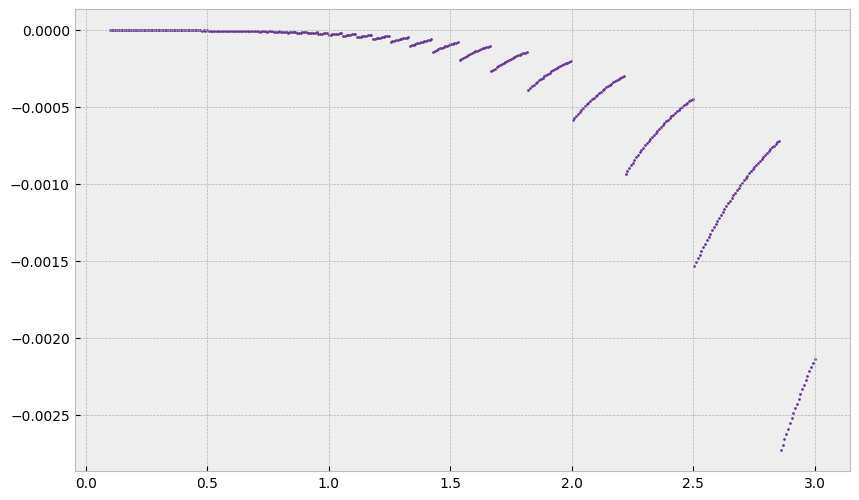

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(time_steps, results, color="rebeccapurple", s=2)

plt.show()

Este es un gráfico bastante extraño porque muestra que a medida que el paso se aumenta, el error aumenta en valor absoluto, sin embargo hay un corpotamiento periodico extraño que parece que se repite donde el error oscila entre valores mayores o menores sin cambiar de signo

### How time step affect oscillatory behaviour

In [67]:
def compute_oscillatory_errors(info: ODEInfo, time_steps: npt.ArrayLike, solver: ODESolver) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    errors_last = []
    errors_second_to_last = []
    for time_step in tqdm(time_steps):
        info = info._replace(time_step=time_step)
        _, y_solution = info.solve(solver)
        difference = np.abs(y_solution[-1] - y_solution[-2])
        error_last = difference / y_solution[-1]
        error_second_to_last = difference / y_solution[-2]
    # plt.plot(x_explicit, y_explicit)
        errors_last.append(np.real(error_last))
        errors_second_to_last.append(np.real(error_second_to_last))
    return np.array(errors_last), np.array(errors_second_to_last)

In [68]:
initial_value = 35
initial_time_step = 2
final_time = 20
coeff = -1
info = ODEInfo(lambda x, y: coeff*y, 35, 1, 20)

stability_limit = 2 / np.abs(coeff)

time_steps = np.linspace(0.1, stability_limit, 400)

oscillatory_limit = - 1 / coeff

#### Explicit Euler

In [69]:
errors_last, errors_second_to_last = compute_oscillatory_errors(info, time_steps, euler_explicit)

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\elcg\AppData\Local\Temp\ipykernel_18204\416285039.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  error_last = difference / y_solution[-1]
100%|██████████| 400/400 [00:00<00:00, 9302.48it/s]


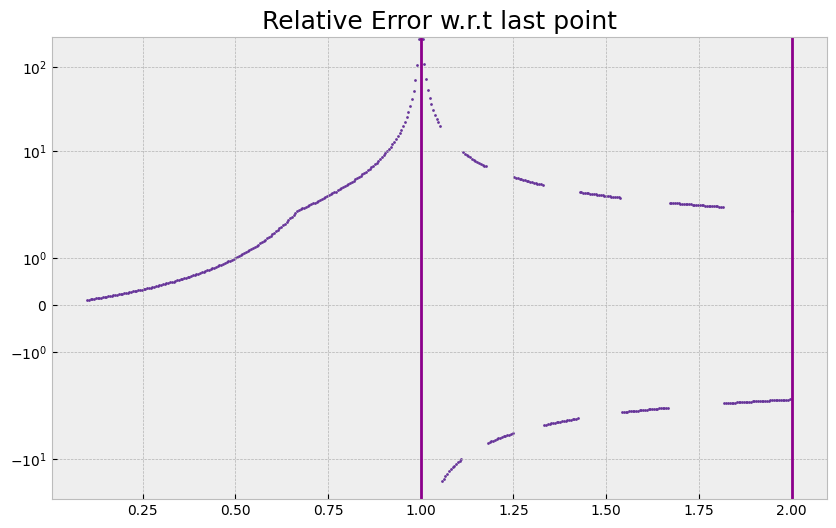

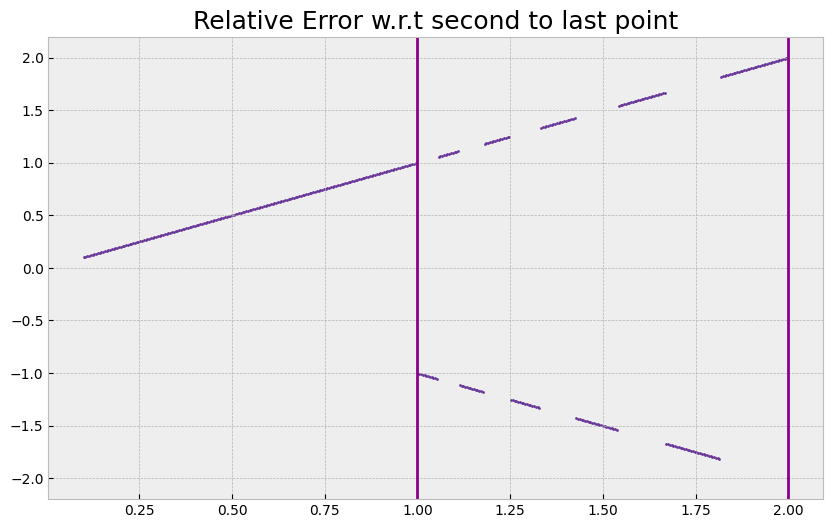

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(time_steps, errors_last, color="rebeccapurple", s=2)

plt.axvline(stability_limit)
plt.axvline(oscillatory_limit)
plt.title("Relative Error w.r.t last point")
plt.yscale('symlog')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(time_steps, errors_second_to_last, color="rebeccapurple", s=2)

plt.axvline(stability_limit)
plt.axvline(oscillatory_limit)
plt.title("Relative Error w.r.t second to last point")
plt.show()

El primer gráfico muestra como a partir de que el producto entre el coeficiente y el paso supera 1 se empiezan a ver discontinuidades y cambios de signo y que antes de que sea 1 el valor absoluto aumenta exponencialmente, encontrandose una singularidad en 1

El segundo gráfico muestra que a medida que se aumenta el paso, la diferencia relativa entre los dos últimos valores de la solución aumenta, pero a partir de 1, no sólo aumenta en valor absoluto sino que además cambia de signo.

#### Implicit Euler

In [ ]:
time_steps = np.linspace(0.1, 10, 400)
errors_last, errors_second_to_last = compute_oscillatory_errors(info, time_steps, euler_implicit)

100%|██████████| 400/400 [00:25<00:00, 15.52it/s]


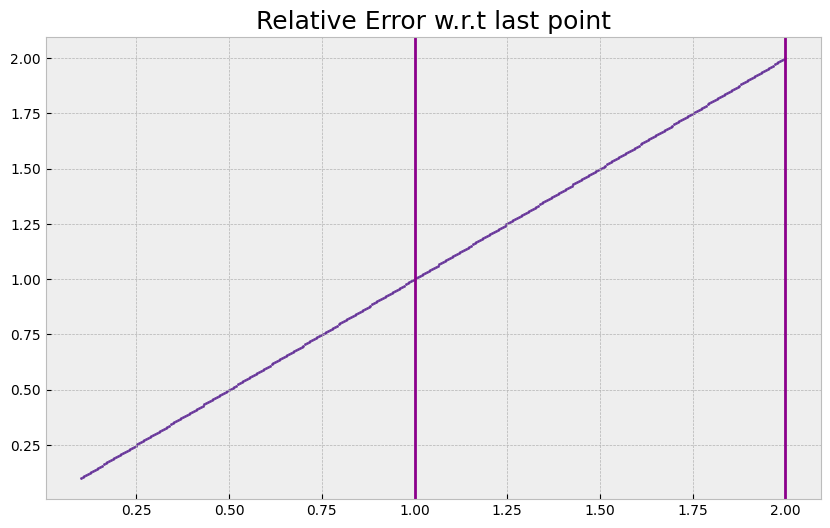

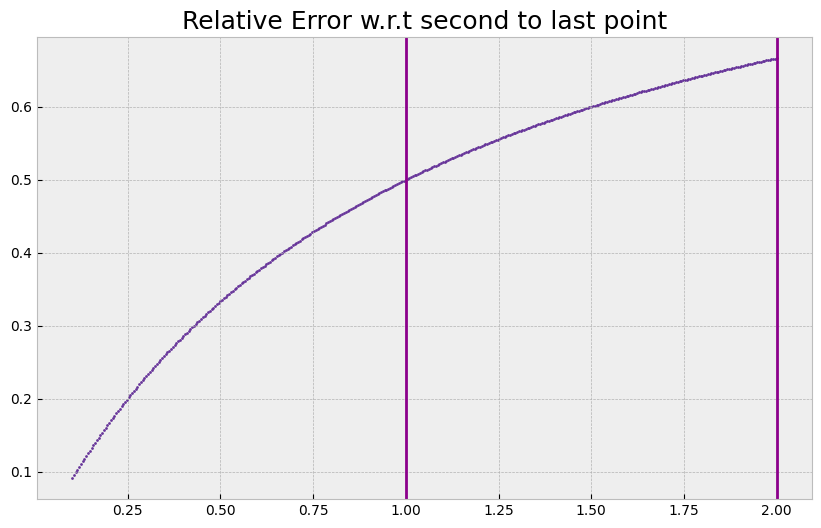

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(time_steps, errors_last, color="rebeccapurple", s=2)

plt.axvline(stability_limit)
plt.axvline(oscillatory_limit)
plt.title("Relative Error w.r.t last point")
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(time_steps, errors_second_to_last, color="rebeccapurple", s=2)

plt.axvline(stability_limit)
plt.axvline(oscillatory_limit)
plt.title("Relative Error w.r.t second to last point")
plt.show()

Estos gráficos muestran como para un coeficiente negativo, el método implicito no presenta singularidades o comportamiento problemático.

En el segundo gráfico se puede ver incluso que pareciera que el crecimiento del error es sub-lineal para grandes tamaños de paso.

### How coefficients oscillatory behaviour

In [73]:
def compute_coefficient_errors(info: ODEInfo, coefficients: npt.ArrayLike, solver: ODESolver) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    last_point = []
    relative_differences_wrt_second_to_last = []
    for real_part in tqdm(coefficients):
        try:
            info = info._replace(function=lambda x, y: real_part * y)
            _, y_solution = info.solve(solver)
            difference = y_solution[-1] - y_solution[-2]
            last_point.append(y_solution[-1])
            relative_differences_wrt_second_to_last.append(np.abs(difference)/ y_solution[-2])
        except:
            last_point.append(np.nan)
            relative_differences_wrt_second_to_last.append(np.nan)
    return np.array(np.real(last_point)), np.array(np.real(relative_differences_wrt_second_to_last))

In [74]:
info = ODEInfo(lambda x, y: None, 35, 1, 20)

#### Explicit Euler

In [75]:
coefficients = np.linspace(-2, 0.5, 400)
last_points, relative_differences_wrt_second_to_lasts = compute_coefficient_errors(info, coefficients, euler_explicit)

100%|██████████| 400/400 [00:00<00:00, 11111.40it/s]


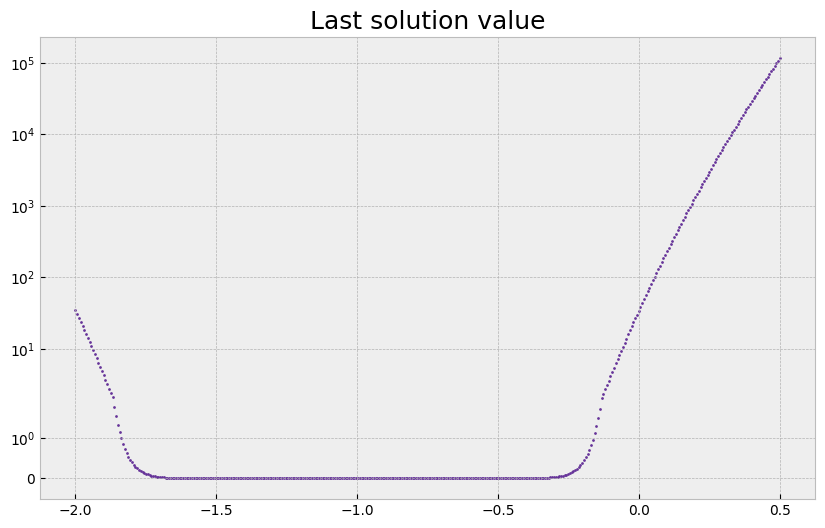

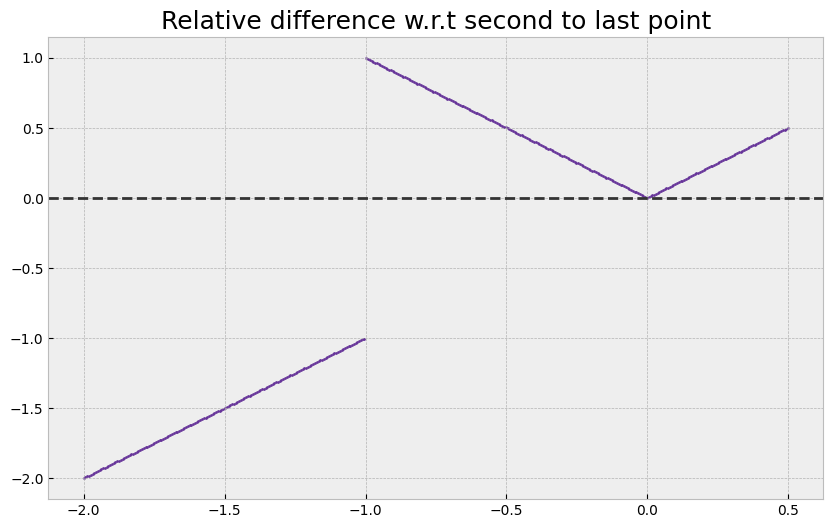

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(coefficients, last_points, color="rebeccapurple", s=2)
plt.title("Last solution value")
plt.yscale("symlog")
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(coefficients, relative_differences_wrt_second_to_lasts, color="rebeccapurple", s=2)
plt.axhline(0, color="#333", ls="--")
plt.title("Relative difference w.r.t second to last point")
plt.show()

El primer gráfico muestra como el error crece desproporcionadamente fuera de la región -2, 0

El segundo gráfico muestra además que para valores donde el producto entre el coeficiente y el paso es menor que -1, la solución presenta oscilaciones donde se cambia el signo en cada iteración.

El segundo gráfico muestra que para valores positivos relativamente pequeños el error puede ser acotado.

#### Implicit Euler

In [77]:
coefficients = np.linspace(-1, 3, 300)
last_points, relative_differences_wrt_second_to_lasts = compute_coefficient_errors(info, coefficients, euler_implicit)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:20<00:00, 14.99it/s]


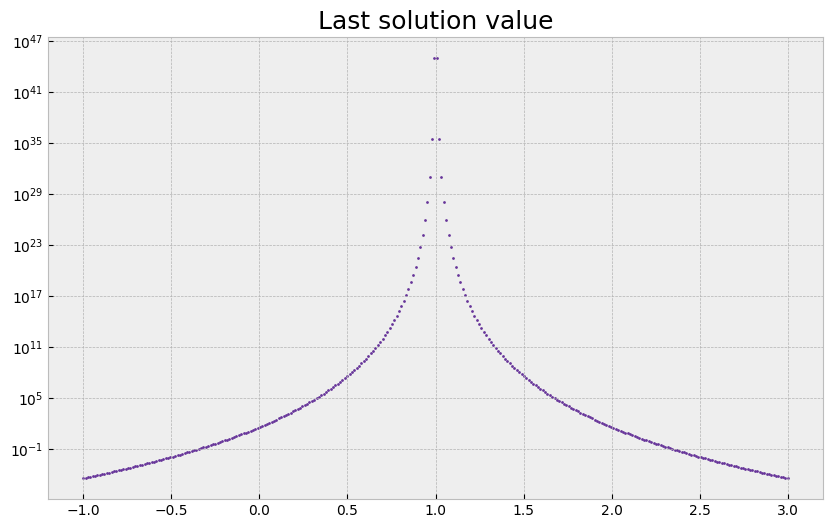

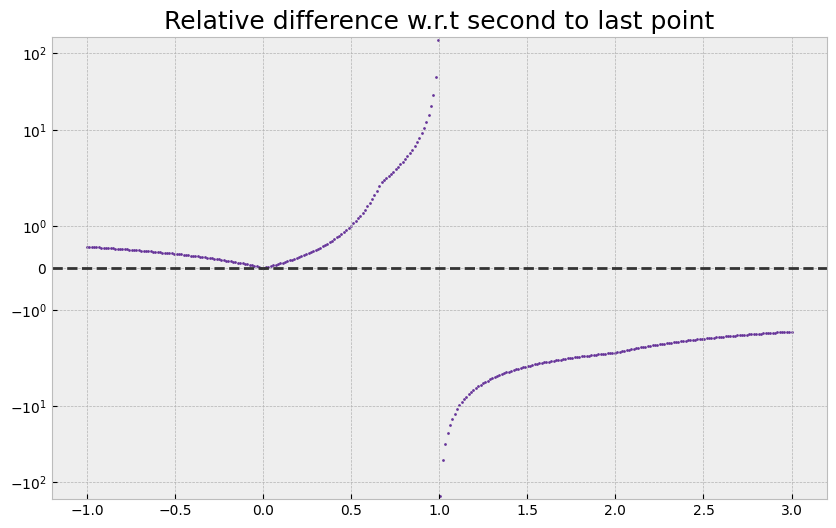

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(coefficients, last_points, color="rebeccapurple", s=2)
plt.title("Last solution value")
plt.yscale("log")
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(coefficients, relative_differences_wrt_second_to_lasts, color="rebeccapurple", s=2)
plt.axhline(0, color="#333", ls="--")
plt.title("Relative difference w.r.t second to last point")
plt.yscale("symlog")
plt.show()

El primer gráfico muestra una singularidad cuando el producto entre el coeficiente y el paso es 1. Para valores mayores o menores a 1, la solución tiende a cero.

El segundo gráfico muestra que para valores menores a 1 la solución se mantiene sin oscilaciones, mientras que para valores superiores a 1 la solución presenta oscilaciones que tienden a cero.

Una diferencia con el método explicito es que en el implícito las oscilaciones siempre tienden a cero, mientras que en el explicito puede haber oscilaciones estables (tendiendo a cero cuando se encuentra en la región -2, -1) u oscilaciones inestables (cuando el producto del paso por los coeficientes es menor a -2).

### Bounded and Oscilatory Regions

In [79]:
def is_bounded(solution: npt.ArrayLike) -> bool:
    return bool(np.abs(solution[-1]) < np.abs(solution[0]))

In [80]:
def is_oscillatory(solution: npt.ArrayLike) -> bool:
    return (
        np.sign(np.real(solution[-1])) != np.sign(np.real(solution[-2]))
    )

In [81]:
def compute_stability_regions(info: ODEInfo, solver: ODESolver, xv: npt.ArrayLike, yv: npt.ArrayLike) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    boundeds = []
    oscillatories = []
    info = ODEInfo(lambda x, y: None, 35, 1, 20)
    for real, imag in tqdm(zip(xv.flatten(), yv.flatten()), total=resolution**2):
        info = info._replace(function=lambda x, y: (real+imag*1j) * y)
        _, solution = info.solve(solver)
        bounded = is_bounded(solution)
        oscillatory = is_oscillatory(solution)
        boundeds.append(bounded)
        oscillatories.append(oscillatory)
    return np.array(boundeds), np.array(oscillatories)

#### Explicit Euler

In [82]:
resolution = 200
x = np.linspace(-2.25, 0.25, resolution)
y = np.linspace(-1.25, 1.25, resolution)
xv, yv = np.meshgrid(x, y)

In [83]:
info = ODEInfo(lambda x, y: -y, 35, 1, 20)
boundeds, oscillatories = compute_stability_regions(info, euler_explicit, xv, yv)

100%|██████████| 40000/40000 [00:09<00:00, 4147.22it/s]


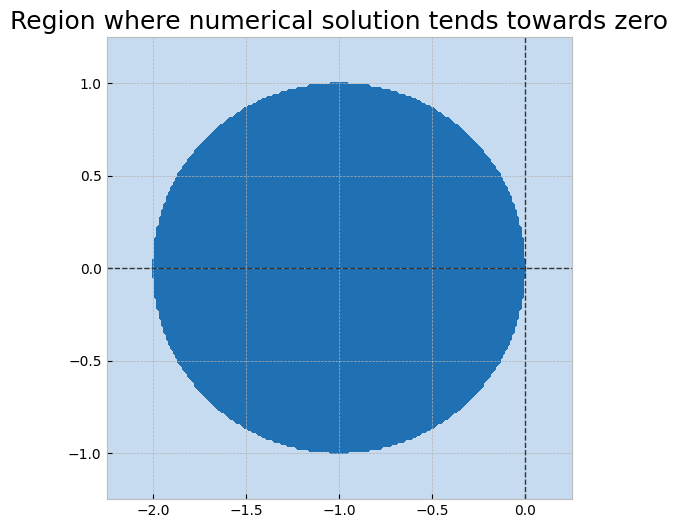

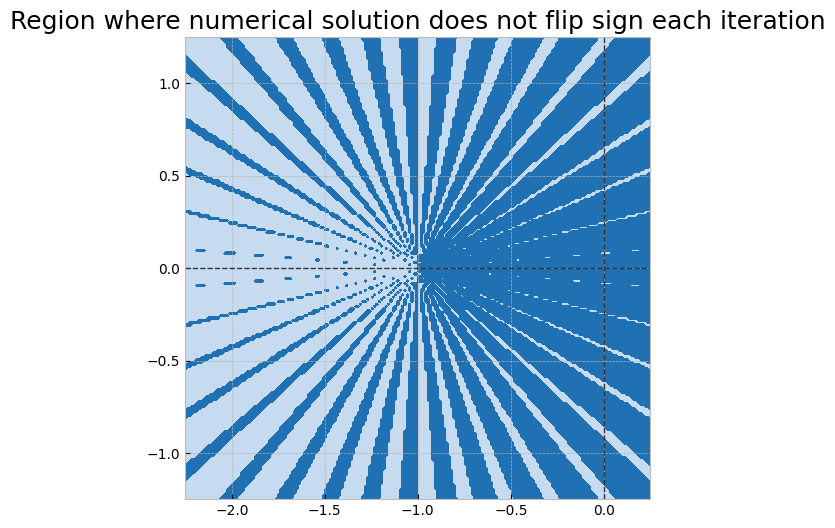

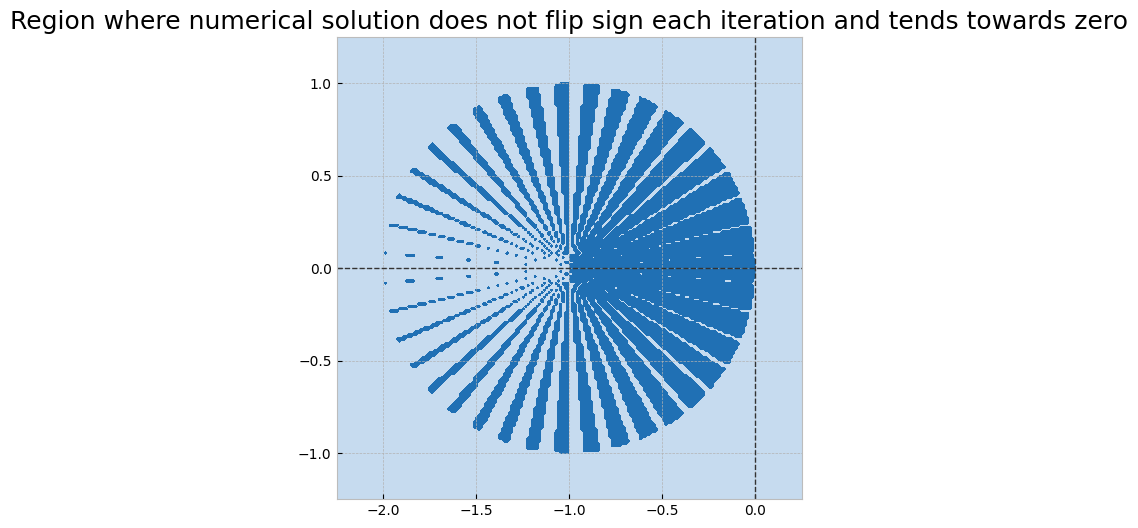

In [84]:
bounded_zs = np.array(boundeds).reshape(resolution, resolution)
oscillatories_zs = np.array(oscillatories).reshape(resolution, resolution)

zs = bounded_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution tends towards zero")
plt.show()

zs = ~oscillatories_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution does not flip sign each iteration")
plt.show()

zs = bounded_zs & ~oscillatories_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution does not flip sign each iteration and tends towards zero")
plt.show()

El primer gráfico muestra que todos los valores cuyo producto entre coeficiente y paso esté dentro del círculo unitario centrado en -1, 0 del plano complejo tenderan a cero, es decir, serán soluciones acotadas o estables.

El segundo gráfico muestras las regiones donde la solución cambiará de signo en cada iteración

El tercer gráfico combina ambos, mostrarndo que sólo un semi-circulo del primero, el que está en -1, 0 es el que presenta comportamiento estable y sin oscilaciones.

Implicit Euler

In [85]:
resolution = 200
x = np.linspace(-0.25, 2.25, resolution)
y = np.linspace(-0.75, 0.75, resolution)
xv, yv = np.meshgrid(x, y)

In [86]:
info = ODEInfo(lambda x, y: None, 35, 1, 20)
boundeds, oscillatories = compute_stability_regions(info, euler_implicit, xv, yv)

100%|██████████| 40000/40000 [2:35:06<00:00,  4.30it/s]    


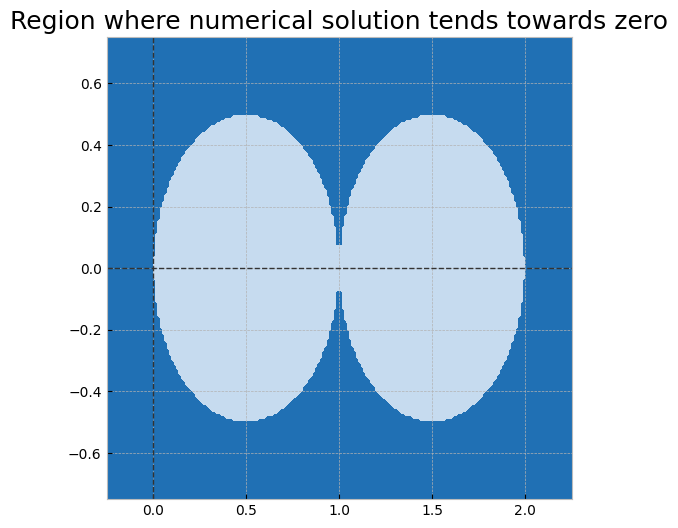

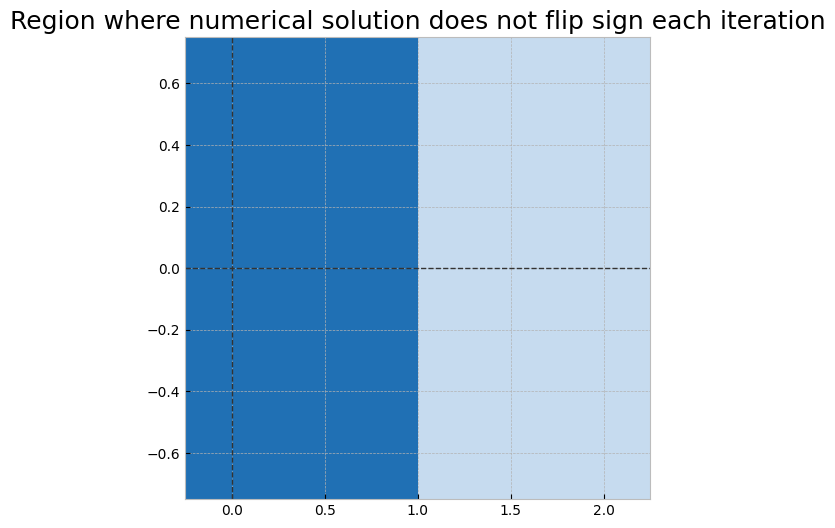

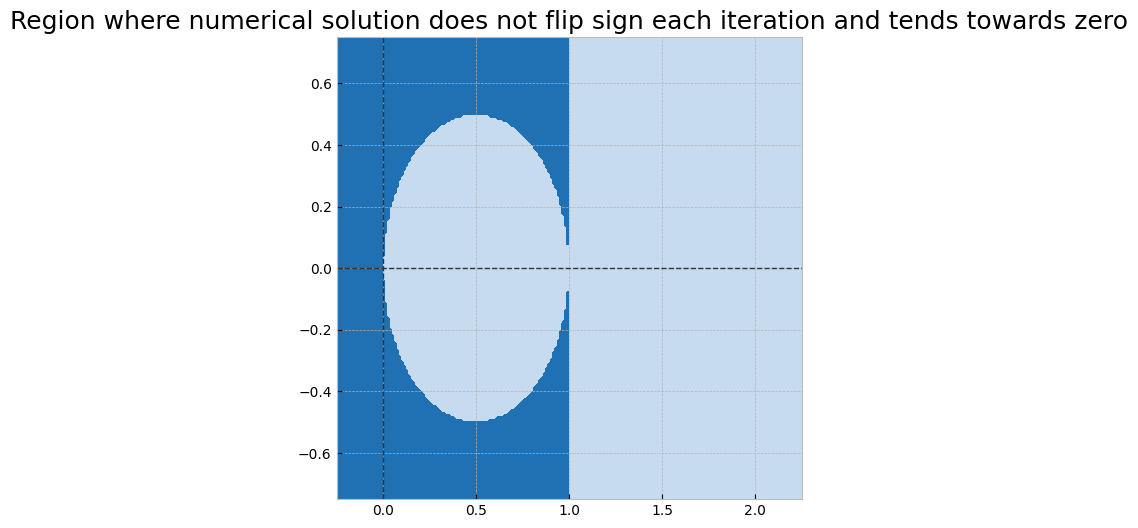

In [87]:
bounded_zs = boundeds.reshape(resolution, resolution)
oscillatories_zs = oscillatories.reshape(resolution, resolution)

zs = bounded_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution tends towards zero")
plt.show()

zs = ~oscillatories_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution does not flip sign each iteration")
plt.show()

zs = bounded_zs & ~oscillatories_zs

plt.figure(figsize=(6, 6))
plt.contourf(xv, yv, zs, cmap='Blues')
plt.axvline(0, color='#333', lw=1, ls="--")
plt.axhline(0, color='#333', lw=1, ls="--")
plt.title("Region where numerical solution does not flip sign each iteration and tends towards zero")
plt.show()

El primer gráfico muestra las zonas donde la solución no es acotada, esto es, dos círculos de radio 0.5, uno en 0.5,0 y el otro en 1.5, 0. Los puntos dentro del primero hacen referencia a soluciones que presentan crecimiento no acotado sin oscilaciones mientras que los puntos del segundo hacen referencia a soluciones con oscilaciones no acotadas.

El tercer gráfico ilustra mejor este punto mostrando que cuando el producto entre los coeficientes y el paso están a la izquierda del 1 en el plano complejo, la solución no tendrá oscilaciones en cada iteración, independientemente de si es acotada o no.

El tercer gráfico muestra la zona en la que la solución será acotada y sin oscilaciones en cada iteración.